<a href="https://colab.research.google.com/github/kuncoroaji212/Klasifikasi-Wayang-Kulit-CNN/blob/master/Klasifikasi_Wayang_VGG_16Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Wayang**

# Mengambil *Dataset* dari *Github*

In [1]:
!apt-get install subversion > /dev/null

!svn export https://github.com/kuncoroaji212/Klasifikasi-Wayang-Kulit-CNN.git/trunk/datawayang > /dev/null

## Persiapan

Program ini dibuat untuk membedakan Wayang yaitu :

1.   Bagong
2.   Petruk
3.   Werkudara

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi *Library*

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

## Mengimpor Dataset

In [3]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls  datawayang/
!ls  datawayang/train
!ls  datawayang/train/Bagong
!ls  datawayang/train/Puntadewa
!ls  datawayang/train/Werkudara

test  train
Bagong	Puntadewa  Werkudara
'Bagong (100).jpg'  'Bagong (32).jpg'  'Bagong (55).jpg'  'Bagong (78).jpg'
'Bagong (10).jpg'   'Bagong (33).jpg'  'Bagong (56).jpg'  'Bagong (79).jpg'
'Bagong (11).jpg'   'Bagong (34).jpg'  'Bagong (57).jpg'  'Bagong (7).jpg'
'Bagong (12).jpg'   'Bagong (35).jpg'  'Bagong (58).jpg'  'Bagong (80).jpg'
'Bagong (13).jpg'   'Bagong (36).jpg'  'Bagong (59).jpg'  'Bagong (81).jpg'
'Bagong (14).jpg'   'Bagong (37).jpg'  'Bagong (5).jpg'   'Bagong (82).jpg'
'Bagong (15).jpg'   'Bagong (38).jpg'  'Bagong (60).jpg'  'Bagong (83).jpg'
'Bagong (16).jpg'   'Bagong (39).jpg'  'Bagong (61).jpg'  'Bagong (84).jpg'
'Bagong (17).jpg'   'Bagong (3).jpg'   'Bagong (62).jpg'  'Bagong (85).jpg'
'Bagong (18).jpg'   'Bagong (40).jpg'  'Bagong (63).jpg'  'Bagong (86).jpg'
'Bagong (19).jpg'   'Bagong (41).jpg'  'Bagong (64).jpg'  'Bagong (87).jpg'
'Bagong (1).jpg'    'Bagong (42).jpg'  'Bagong (65).jpg'  'Bagong (88).jpg'
'Bagong (20).jpg'   'Bagong (43).jpg'  'Bagong (6

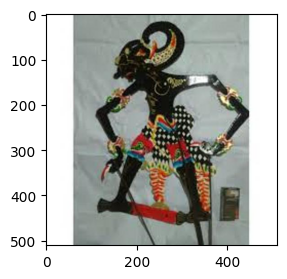

In [4]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("datawayang/train/Werkudara/Werkudara (35).jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [5]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('datawayang/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )
      
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Bagong', 'Puntadewa', 'Werkudara']

for i,label in enumerate(labels):
    folder = os.path.join("datawayang/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (60, 224, 224, 3) (60, 3)
Bentuk array dari dataset test (pengujian) adalah: (60, 224, 224, 3) (60,)


## Menyimpan Label

In [6]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Bagong': 0, 'Puntadewa': 1, 'Werkudara': 2}


In [7]:
!cat labels.txt

Bagong
Puntadewa
Werkudara

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [8]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


## *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [9]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Mengelompokkan Klasifikasi wayang dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [10]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [11]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [12]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


## Pelatihan

In [13]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Wayang.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 1.2359 - acc: 0.3583 - val_loss: 1.3135 - val_acc: 0.3333
Epoch 2/100
2/2 [==============================] - 1s 444ms/step - loss: 1.2474 - acc: 0.3333 - val_loss: 0.9323 - val_acc: 0.6500
Epoch 3/100
2/2 [==============================] - 1s 430ms/step - loss: 0.9339 - acc: 0.6708 - val_loss: 0.8836 - val_acc: 0.6500
Epoch 4/100
2/2 [==============================] - 1s 447ms/step - loss: 0.8686 - acc: 0.6208 - val_loss: 0.7684 - val_acc: 0.6500
Epoch 5/100
2/2 [==============================] - 1s 433ms/step - loss: 0.7488 - acc: 0.6750 - val_loss: 0.6176 - val_acc: 0.8833
Epoch 6/100
2/2 [==============================] - 1s 479ms/step - loss: 0.6077 - acc: 0.9292 - val_loss: 0.5560 - val_acc: 0.8833
Epoch 7/100
2/2 [==============================] - 1s 446ms/step - loss: 0.5217 - acc: 0.9333 - val_loss: 0.4736 - val_acc: 0.9000
Epoch 8/10

## Menggambarkan Hasil Pelatihan

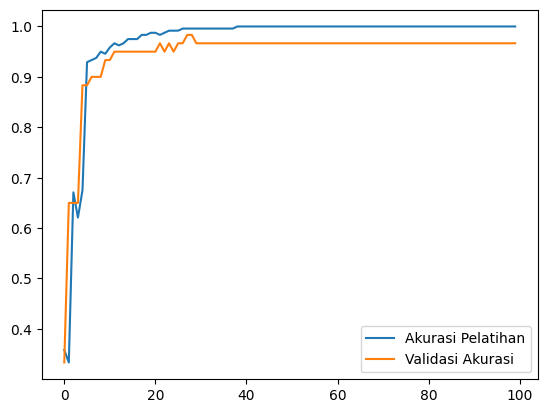

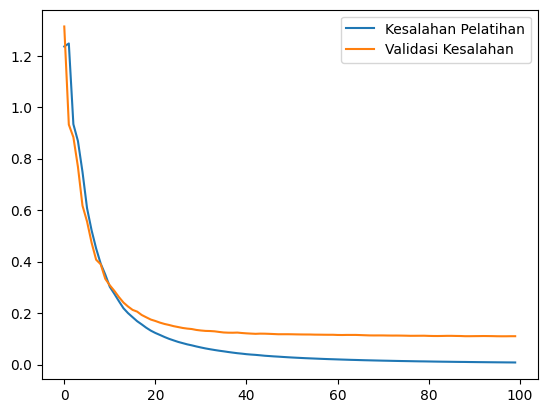

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [16]:
print(train_generator)

In [17]:
#Prediksi Label Validasi dengan Pelatihan
n = 59
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah [1.4286592e-04 9.9985623e-01 8.1684902e-07]


Hasil tersebut merupakan hasil prediksi dari training 3 data. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [18]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
2/2 [==============================] - 1s 344ms/step - loss: 0.1684 - acc: 0.9333
[0.16842564940452576, 0.9333333373069763]


In [19]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 1 1 2 2 2 2 0 2 2 2 2 2 0 2 2 2]


## Prediksi Gambar Individual

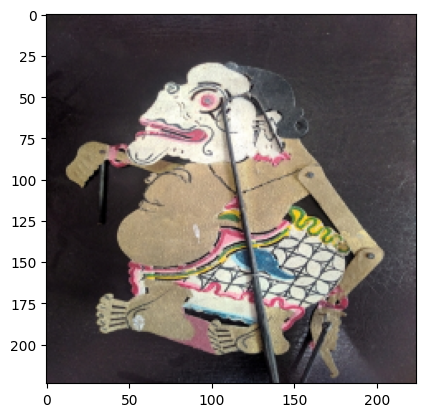

Label yang benar adalah: 0 : Bagong
Nilai yang diprediksi adalah: [9.9771154e-01 1.8140423e-04 2.1070582e-03]
Label yang diprediksi adalah: 0 : Bagong
Prediksi benar


In [20]:
n = 4 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

Normalized confusion matrix
[[1.  0.  0. ]
 [0.  1.  0. ]
 [0.1 0.1 0.8]]


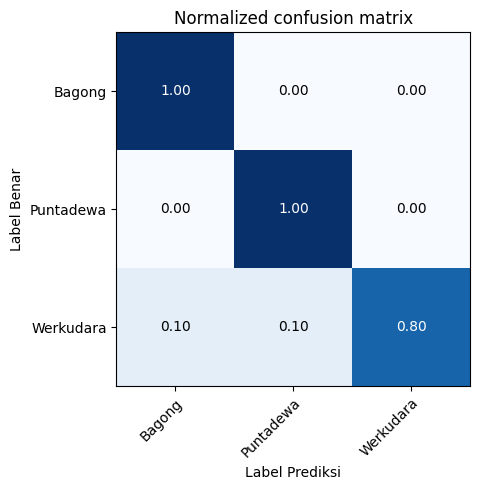

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [22]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
